In [2]:
# TensorFlow and tf.keras
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Reshape
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
from PIL import Image

In [8]:
Dataset = '/content/drive/MyDrive/images'

In [9]:
Images = []
for y in os.listdir(Dataset):
  Images.append(Dataset+'/'+y)


In [10]:
Images.__len__()

809

In [11]:
X_data = np.empty((len(Images),64, 64,3), dtype='float32')

In [12]:
i = 0
for x in Images:
  im = plt.imread(x).astype('int16').astype('float32')
  im = cv2.resize(im, dsize = (64, 64), interpolation=cv2.INTER_NEAREST)
  img = (im - np.min(im))/ (np.max(im)- np.min(im))
  X_data[i] = img[:,:,:3]
  i+=1

In [13]:
gen_optimizer=Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [14]:
# Generator 
def BuildGenerator():
  generator = Sequential()
  
  generator.add(Dense(1024, input_dim= noise_dim))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation('relu'))

  generator.add(Dense(8192, input_dim = noise_dim))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Activation('relu'))

  generator.add(Reshape((8, 8, 128)))

  generator.add(UpSampling2D((2, 2)))
  generator.add(Conv2D(64, (2, 2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D((2,2)))
  generator.add(Conv2D(64, (2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(UpSampling2D((2,2)))
  generator.add(Conv2D(3, (3,3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
  return generator


In [15]:
generator = BuildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_1 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0

In [16]:
def buildDiscriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (5,5), strides=2, padding='same', kernel_initializer = RandomNormal(0, 0.02), input_shape=(64, 64, 3)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(64, (5,5), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(64, 64, 3)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128, (5,5), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dense(256))
  discriminator.add(Dropout(0.2))
  
  discriminator.add(Dense(1, activation='sigmoid'))

  discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
  return discriminator

In [17]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
noise = Input(shape=(noise_dim),)
fake_data = generator(noise)
discriminator.trainable=False
output=discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [19]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         8588355   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 2409921   
Total params: 10,998,276
Trainable params: 8,569,795
Non-trainable params: 2,428,481
_________________________________________________________________


In [30]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [33]:
def show_generated_image(title, epoch):
  imgs = generator.predict(fixed_noise)
  imgs = 0.5*imgs + 0.5

  plt.figure(figsize=(12, 12))

  i = 1
  for img in imgs:
      plt.subplot(10, 10, i)
      plt.imshow(img.reshape((64, 64, 3)))
      plt.axis('off')
      i+=1
  plt.suptitle(title, fontsize=20)
  plt.savefig(str(epoch+1)+'.png', transparent=True)
  plt.show()

In [22]:
epochs= 100
batch_size = 256
steps_per_epochs = len(X_data)//batch_size

epochs =  0
discriminator =  0.33918893337249756
generator =  2.3535571098327637
epochs =  1
discriminator =  0.36438798904418945
generator =  2.8804476261138916
epochs =  2
discriminator =  0.35101112723350525
generator =  2.4853768348693848
epochs =  3
discriminator =  0.8792176246643066
generator =  0.6144373416900635
epochs =  4
discriminator =  0.35594338178634644
generator =  2.1497626304626465
epochs =  5
discriminator =  0.35186368227005005
generator =  2.133913516998291
epochs =  6
discriminator =  0.3497483432292938
generator =  1.8762612342834473
epochs =  7
discriminator =  0.34884941577911377
generator =  2.5009937286376953
epochs =  8
discriminator =  0.3386525809764862
generator =  2.141850233078003
epochs =  9
discriminator =  0.3368760645389557
generator =  2.044654369354248
epochs =  10
discriminator =  0.3373778760433197
generator =  2.435666561126709
epochs =  11
discriminator =  0.33732300996780396
generator =  2.621471405029297
epochs =  12
discriminator =  0.3833

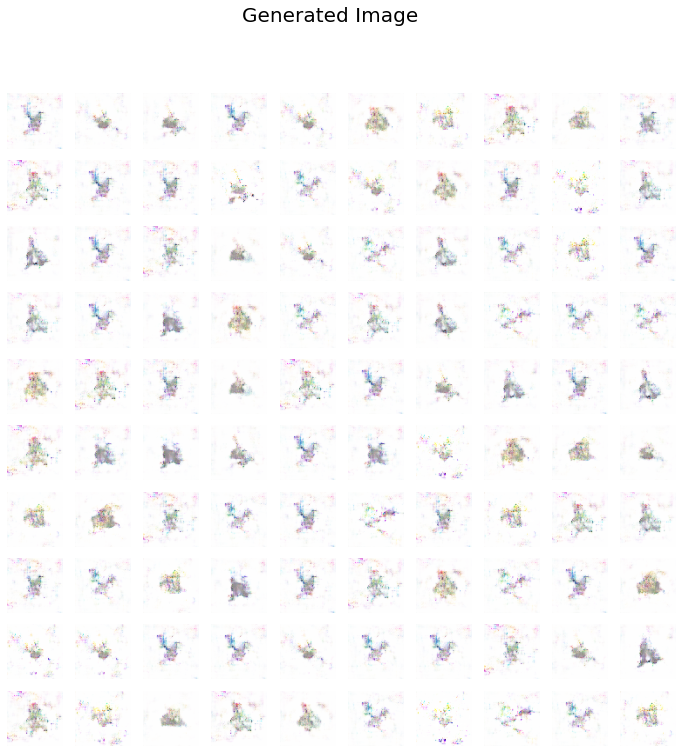

epochs =  20
discriminator =  0.33432868123054504
generator =  2.39841890335083
epochs =  21
discriminator =  0.33194831013679504
generator =  2.4142251014709473
epochs =  22
discriminator =  0.3321834206581116
generator =  1.8575291633605957
epochs =  23
discriminator =  0.3542894721031189
generator =  1.7596088647842407
epochs =  24
discriminator =  0.3310011625289917
generator =  1.9967998266220093
epochs =  25
discriminator =  0.32951244711875916
generator =  2.0175588130950928
epochs =  26
discriminator =  0.3306558132171631
generator =  2.221903085708618
epochs =  27
discriminator =  0.4104367196559906
generator =  1.8552284240722656
epochs =  28
discriminator =  0.4101186990737915
generator =  1.4332401752471924
epochs =  29
discriminator =  0.39775341749191284
generator =  1.5571035146713257
epochs =  30
discriminator =  0.38837528228759766
generator =  1.7120885848999023
epochs =  31
discriminator =  0.35520869493484497
generator =  2.3517777919769287
epochs =  32
discriminato

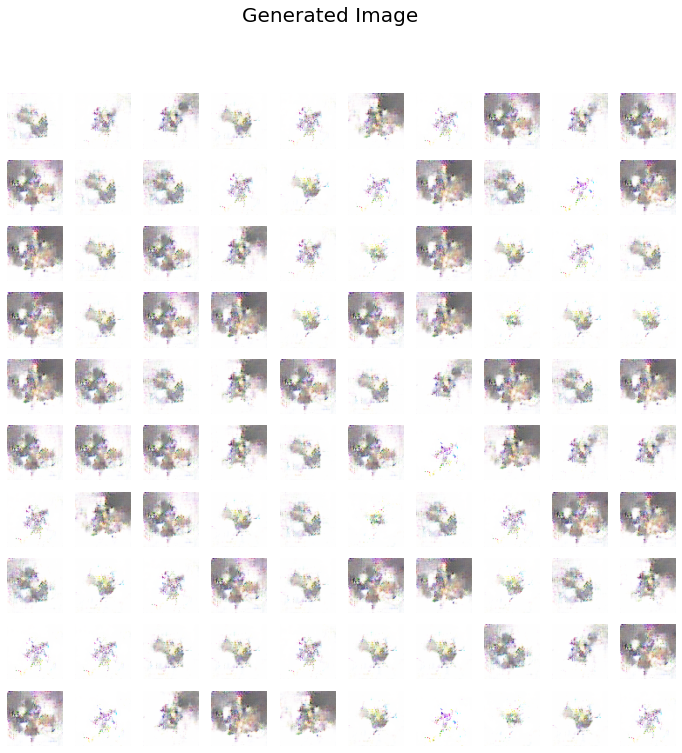

epochs =  40
discriminator =  0.332450807094574
generator =  1.8975334167480469
epochs =  41
discriminator =  0.3321419954299927
generator =  2.076930522918701
epochs =  42
discriminator =  0.3315044939517975
generator =  1.9958432912826538
epochs =  43
discriminator =  0.33000001311302185
generator =  2.031719207763672
epochs =  44
discriminator =  0.33050838112831116
generator =  2.1722328662872314
epochs =  45
discriminator =  0.33084532618522644
generator =  2.6154532432556152
epochs =  46
discriminator =  0.3297017514705658
generator =  2.2961671352386475
epochs =  47
discriminator =  0.3291952311992645
generator =  1.9905377626419067
epochs =  48
discriminator =  0.33911415934562683
generator =  2.123572587966919
epochs =  49
discriminator =  0.35050663352012634
generator =  3.497878313064575
epochs =  50
discriminator =  0.404310017824173
generator =  2.0305323600769043
epochs =  51
discriminator =  0.3741758167743683
generator =  2.2510645389556885
epochs =  52
discriminator = 

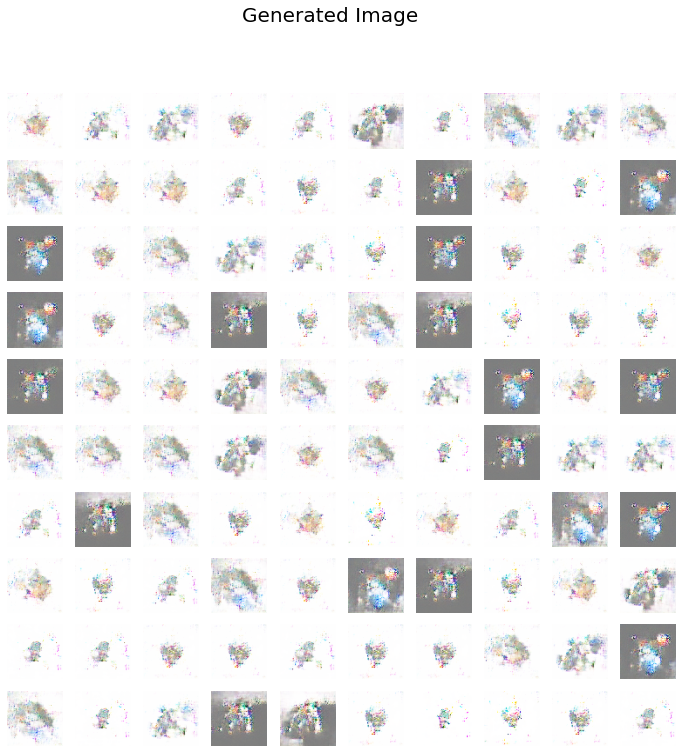

epochs =  60
discriminator =  0.33330416679382324
generator =  2.48311448097229
epochs =  61
discriminator =  0.3286467492580414
generator =  2.109531879425049
epochs =  62
discriminator =  0.33330368995666504
generator =  1.9256703853607178
epochs =  63
discriminator =  0.32917389273643494
generator =  2.4496877193450928
epochs =  64
discriminator =  0.779573380947113
generator =  4.751206398010254
epochs =  65
discriminator =  0.33112281560897827
generator =  2.382535457611084
epochs =  66
discriminator =  0.331726610660553
generator =  2.4865565299987793
epochs =  67
discriminator =  0.3291357159614563
generator =  2.233189344406128
epochs =  68
discriminator =  0.3306506872177124
generator =  2.636732339859009
epochs =  69
discriminator =  0.32895389199256897
generator =  2.0363879203796387
epochs =  70
discriminator =  0.3286297619342804
generator =  2.4963693618774414
epochs =  71
discriminator =  0.3273838460445404
generator =  2.2166693210601807
epochs =  72
discriminator =  0.

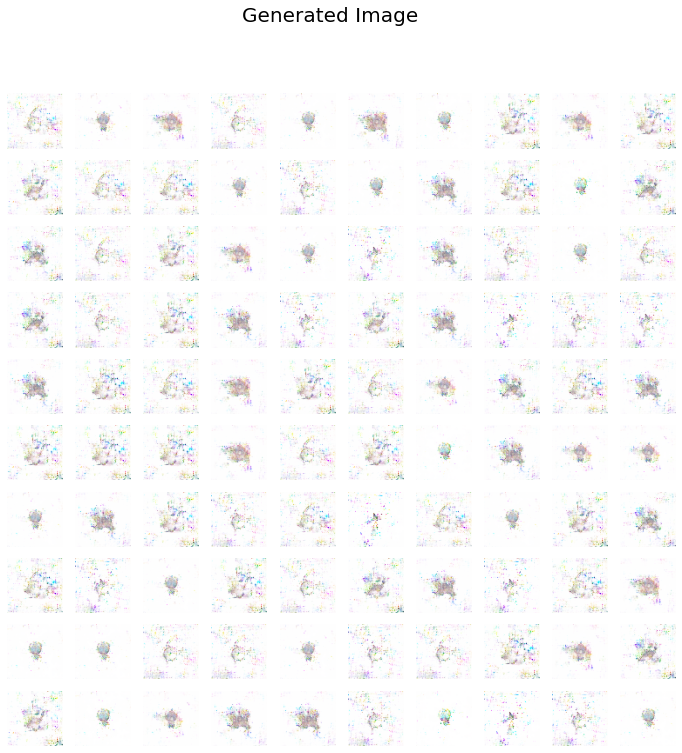

epochs =  80
discriminator =  0.3311738669872284
generator =  2.011685371398926
epochs =  81
discriminator =  0.3328230679035187
generator =  1.890517234802246
epochs =  82
discriminator =  0.32859885692596436
generator =  2.1439785957336426
epochs =  83
discriminator =  0.3271457552909851
generator =  2.2668893337249756
epochs =  84
discriminator =  0.3266044855117798
generator =  2.5054683685302734
epochs =  85
discriminator =  0.3318231999874115
generator =  1.9834774732589722
epochs =  86
discriminator =  0.32753515243530273
generator =  2.2927796840667725
epochs =  87
discriminator =  0.3264329135417938
generator =  2.238442897796631
epochs =  88
discriminator =  0.3298800587654114
generator =  2.308011054992676
epochs =  89
discriminator =  0.3298647403717041
generator =  2.20151424407959
epochs =  90
discriminator =  0.3561643660068512
generator =  1.8284355401992798
epochs =  91
discriminator =  0.33822816610336304
generator =  2.118840456008911
epochs =  92
discriminator =  0.

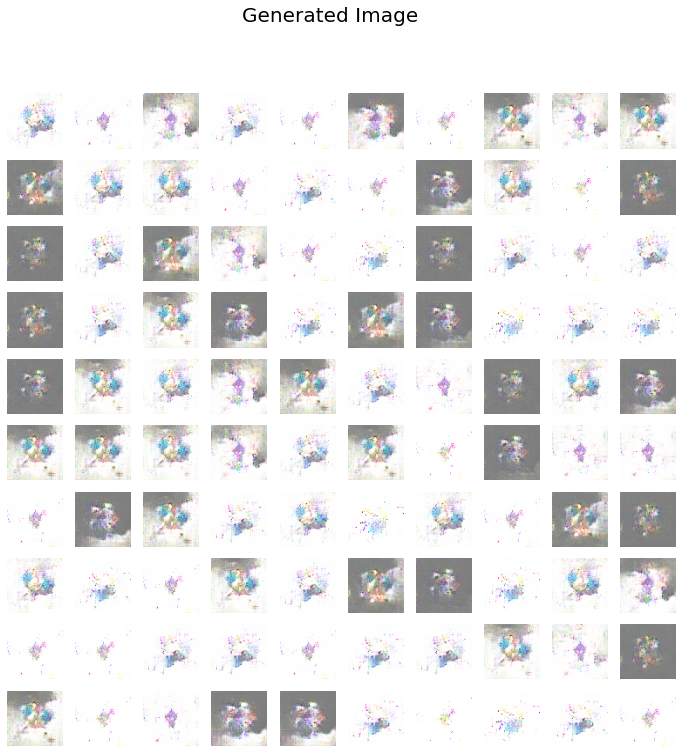

In [35]:
for epoch in range(epochs):
  for batch in range(batch_size):
    input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
    fake_data = generator.predict(input_gen)

    real_data = X_data[np.random.randint(0, X_data.shape[0], size=batch_size )]
    real_data = real_data.reshape((batch_size, 64, 64, 3))

    input_disc = np.concatenate((real_data, fake_data))

    label_disc = np.zeros(2*batch_size)
    label_disc[:batch_size] = 0.9
    label_disc[batch_size:] = 0.1
    loss_disc = discriminator.train_on_batch(input_disc, label_disc)

    label_gen = np.ones(batch_size)
    loss_gen = gan.train_on_batch(input_gen, label_gen)
    
  print('epochs = ', epoch)
  print('discriminator = ', loss_disc)
  print('generator = ', loss_gen)
  
  if (epoch+1) % 20 == 0:
    show_generated_image('Generated Image', epoch)
    